<a href="https://colab.research.google.com/github/HEsiyun/cv-lab3/blob/main/cv_lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 877.7/877.7 kB 23.1 MB/s eta 0:00:00


In [2]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [3]:
!rm -rf /content/dataset
!rm -rf /content/yolov8_dataset
!rm -rf /content/darknet
!rm -rf /content/yolov8_finetune

In [4]:
!nvidia-smi

Tue Oct 29 05:55:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
import gdown
import zipfile

# Google Drive file ID
file_id = "19W45cMfvBnhV0vqBVJgUHHpe7WC1YLdG"
url = f"https://drive.google.com/uc?export=download&id={file_id}"

# Download the file using gdown
gdown.download(url, "/content/dataset.zip", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=19W45cMfvBnhV0vqBVJgUHHpe7WC1YLdG
From (redirected): https://drive.google.com/uc?export=download&id=19W45cMfvBnhV0vqBVJgUHHpe7WC1YLdG&confirm=t&uuid=204d838f-e74c-4da5-82b0-ed65a10de12e
To: /content/dataset.zip
100%|██████████| 211M/211M [00:01<00:00, 142MB/s]


'/content/dataset.zip'

In [6]:
# Extract the zip file
try:
    with zipfile.ZipFile("/content/dataset.zip", 'r') as zip_ref:
        zip_ref.extractall("/content/dataset")
    print("Dataset downloaded and unzipped successfully.")
except zipfile.BadZipFile:
    print("Error: The downloaded file is not a valid zip file.")

Dataset downloaded and unzipped successfully.


In [7]:
import os
import shutil
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split

# Paths to the dataset
images_dir = '/content/dataset/filtered_images'
annotations_dir = '/content/dataset/filtered_annotations'
# Output directory for YOLOv8 training data
output_dir = '/content/yolov8_dataset'
os.makedirs(output_dir, exist_ok=True)

# Create directories for train, val, and test
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get a list of image files
image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg') or f.endswith('.png')]

# Split the data into train, validation, and test sets
train_files, temp_files = train_test_split(image_files, test_size=0.3, random_state=42)  # 70% train
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)  # 15% val, 15% test

# Function to convert XML annotations to YOLO format and save as .txt
def convert_xml_to_yolo(xml_file, img_width, img_height):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    yolo_lines = []
    for obj in root.findall('object'):
        class_name = obj.find('name').text
        # Convert class name to an index
        class_id = 0

        bndbox = obj.find('bndbox')
        xmin = float(bndbox.find('xmin').text)
        ymin = float(bndbox.find('ymin').text)
        xmax = float(bndbox.find('xmax').text)
        ymax = float(bndbox.find('ymax').text)

        # Convert to YOLO format (normalized coordinates)
        x_center = (xmin + xmax) / 2 / img_width
        y_center = (ymin + ymax) / 2 / img_height
        width = (xmax - xmin) / img_width
        height = (ymax - ymin) / img_height

        yolo_lines.append(f"{class_id} {x_center} {y_center} {width} {height}")

    return yolo_lines

# Function to parse XML and retrieve image dimensions
def get_image_dimensions_from_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    size = root.find('size')
    img_width = int(size.find('width').text)
    img_height = int(size.find('height').text)
    return img_width, img_height

# Function to copy images and corresponding annotations
def copy_files_and_convert_labels(file_list, source_dir, dest_dir, annotation_dir):
    for filename in file_list:
        # Copy image files
        src_img_path = os.path.join(source_dir, filename)
        dest_img_path = os.path.join(dest_dir, filename)
        shutil.copy(src_img_path, dest_img_path)

        # Get image dimensions from the annotation file
        base_name = os.path.splitext(filename)[0]
        src_label_path = os.path.join(annotation_dir, base_name + '.xml')

        if os.path.exists(src_label_path):
            img_width, img_height = get_image_dimensions_from_xml(src_label_path)

            # Convert and save corresponding annotation files
            yolo_lines = convert_xml_to_yolo(src_label_path, img_width, img_height)
            dest_label_path = os.path.join(dest_dir, base_name + '.txt')
            with open(dest_label_path, 'w') as f:
                f.write('\n'.join(yolo_lines))

# Copy files to their respective directories and convert labels
copy_files_and_convert_labels(train_files, images_dir, train_dir, annotations_dir)
copy_files_and_convert_labels(val_files, images_dir, val_dir, annotations_dir)
copy_files_and_convert_labels(test_files, images_dir, test_dir, annotations_dir)

print("Dataset organized and annotations converted to YOLO format:")
print(f"- Train images: {len(train_files)}")
print(f"- Validation images: {len(val_files)}")
print(f"- Test images: {len(test_files)}")

Dataset organized and annotations converted to YOLO format:
- Train images: 2993
- Validation images: 642
- Test images: 642


In [8]:
import os

# Define the base directory where your dataset is located
base_dir = "/content/yolov8_dataset"

# Define the paths for train, val, and test directories
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Define the class names
import os
import xml.etree.ElementTree as ET

# Define the path to the annotations directory
annotations_dir = '/content/dataset/filtered_annotations'

# Convert the set to a sorted list
class_names = [0]

# Create the data.yaml content
data_yaml_content = f"""
# YOLOv8 data configuration file

# Base directory of the dataset
path: {base_dir}

# Paths for training, validation, and testing image directories
train: {train_dir}
val: {val_dir}
test: {test_dir}

# Number of classes
nc: {len(class_names)}

# Class names
names:
"""

# Add class names to the YAML content
for i, name in enumerate(class_names):
    data_yaml_content += f"  {i}: '{name}'\n"

# Write the content to data.yaml
data_yaml_path = os.path.join('/content/yolov8_dataset', "data.yaml")
with open(data_yaml_path, "w") as file:
    file.write(data_yaml_content)

print("data.yaml file has been created successfully at:", data_yaml_path)

data.yaml file has been created successfully at: /content/yolov8_dataset/data.yaml


In [9]:
from ultralytics import YOLO

# Load a pretrained YOLOv8n model
model = YOLO('yolov8n.pt')  # load a pretrained model

# Define the path to the data.yaml file
data_yaml_path = '/content/yolov8_dataset/data.yaml'

# Fine-tune the model on the custom dataset
results = model.train(
    data=data_yaml_path,          # Path to the dataset configuration (data.yaml)
    epochs=30,                    # Increased number of epochs for fine-tuning
    imgsz=640,                    # Image size for training
    patience=10,                  # Early stopping patience (if no improvement after 10 epochs)
    device=[0],                   # Specify the device (e.g., GPU 0)
    optimizer='Adam',             # Using Adam optimizer for training
    lr0=0.0001,                   # Lower initial learning rate for fine-tuning
    lrf=0.01,                     # Final learning rate (after warm-up)
    warmup_epochs=2,              # Warm-up for 2 epochs (to avoid abrupt changes in gradients)
    freeze=[0, 1, 2, 3],          # Freezing all layers except the last layer (adjust if needed)
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 104MB/s]


Ultralytics 8.3.24 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/yolov8_dataset/data.yaml, epochs=30, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=[0], workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=[0, 1, 2, 3], multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tru

100%|██████████| 755k/755k [00:00<00:00, 22.1MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 93.3MB/s]


AMP: checks passed ✅


train: Scanning /content/yolov8_dataset/train... 2993 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2993/2993 [00:01<00:00, 1692.33it/s]


train: New cache created: /content/yolov8_dataset/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/yolov8_dataset/val... 642 images, 0 backgrounds, 0 corrupt: 100%|██████████| 642/642 [00:00<00:00, 799.54it/s]

val: New cache created: /content/yolov8_dataset/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: Adam(lr=0.0001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      1.72G     0.6632      1.033      1.008          5        640: 100%|██████████| 188/188 [01:03<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.23it/s]


                   all        642       2038      0.953      0.911      0.965      0.889

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      1.52G     0.5677     0.6349     0.9753          7        640: 100%|██████████| 188/188 [01:00<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:07<00:00,  2.93it/s]

                   all        642       2038      0.978      0.957      0.986      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      1.51G     0.5429     0.5609     0.9679          4        640: 100%|██████████| 188/188 [00:56<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:07<00:00,  2.88it/s]

                   all        642       2038      0.977      0.955      0.986       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      1.51G     0.5195     0.5262     0.9573         11        640: 100%|██████████| 188/188 [00:57<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.94it/s]

                   all        642       2038      0.981      0.962       0.99      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      1.51G     0.5105     0.5114     0.9531          6        640: 100%|██████████| 188/188 [00:57<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.54it/s]

                   all        642       2038      0.979      0.966       0.99       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      1.53G     0.5047     0.5023     0.9504          3        640: 100%|██████████| 188/188 [00:57<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.02it/s]

                   all        642       2038      0.985      0.958      0.992      0.948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      1.51G     0.4955     0.4831     0.9491          6        640: 100%|██████████| 188/188 [00:57<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.45it/s]

                   all        642       2038      0.978      0.968      0.992      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      1.51G     0.4926     0.4736     0.9471          3        640: 100%|██████████| 188/188 [00:57<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.08it/s]

                   all        642       2038      0.988       0.97      0.992      0.947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      1.54G     0.4881      0.466     0.9429          3        640: 100%|██████████| 188/188 [00:58<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.24it/s]

                   all        642       2038      0.986      0.974      0.992      0.949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      1.54G     0.4787     0.4488     0.9352          9        640: 100%|██████████| 188/188 [00:56<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.00it/s]


                   all        642       2038      0.987      0.972      0.993      0.951

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      1.54G     0.4803     0.4518       0.94          3        640: 100%|██████████| 188/188 [00:57<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.04it/s]

                   all        642       2038       0.99      0.969      0.993      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      1.52G     0.4738     0.4416     0.9363          6        640: 100%|██████████| 188/188 [00:57<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.50it/s]

                   all        642       2038       0.99      0.968      0.993       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      1.51G     0.4657     0.4374     0.9322          4        640: 100%|██████████| 188/188 [00:56<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.09it/s]

                   all        642       2038       0.99      0.972      0.993      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      1.57G     0.4667     0.4328      0.938          5        640: 100%|██████████| 188/188 [00:55<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:07<00:00,  2.81it/s]

                   all        642       2038      0.989      0.971      0.993      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      1.54G     0.4639     0.4224     0.9312          6        640: 100%|██████████| 188/188 [00:55<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.11it/s]

                   all        642       2038      0.988      0.974      0.993      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      1.51G     0.4657     0.4256     0.9371          4        640: 100%|██████████| 188/188 [00:58<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.04it/s]

                   all        642       2038       0.99      0.975      0.994      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      1.54G     0.4571     0.4169     0.9288          9        640: 100%|██████████| 188/188 [00:57<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:07<00:00,  2.92it/s]

                   all        642       2038      0.991      0.975      0.994      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      1.51G     0.4552     0.4168     0.9287         10        640: 100%|██████████| 188/188 [00:58<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.94it/s]

                   all        642       2038      0.988      0.977      0.994      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      1.51G     0.4557     0.4181     0.9307          8        640: 100%|██████████| 188/188 [00:57<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.52it/s]

                   all        642       2038      0.988      0.974      0.994       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      1.56G     0.4533     0.4079      0.928          4        640: 100%|██████████| 188/188 [00:55<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.44it/s]

                   all        642       2038      0.992      0.976      0.994       0.96


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      1.69G     0.3812     0.3285     0.8848          2        640: 100%|██████████| 188/188 [00:57<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.05it/s]

                   all        642       2038       0.99      0.976      0.993      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      1.54G     0.3832      0.321     0.8901          2        640: 100%|██████████| 188/188 [00:54<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:07<00:00,  2.84it/s]

                   all        642       2038      0.988      0.976      0.994      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      1.54G     0.3774     0.3151     0.8823          4        640: 100%|██████████| 188/188 [00:54<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  4.02it/s]

                   all        642       2038      0.988      0.978      0.994      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      1.54G     0.3729     0.3089     0.8803          4        640: 100%|██████████| 188/188 [00:53<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.12it/s]

                   all        642       2038      0.988      0.977      0.994      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      1.54G     0.3714     0.3043     0.8789          2        640: 100%|██████████| 188/188 [00:54<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.92it/s]

                   all        642       2038      0.986      0.979      0.994      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      1.54G      0.375      0.306     0.8849          2        640: 100%|██████████| 188/188 [00:54<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.17it/s]

                   all        642       2038      0.987      0.977      0.994      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      1.54G      0.372     0.3028     0.8835          2        640: 100%|██████████| 188/188 [00:56<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.81it/s]

                   all        642       2038      0.991      0.972      0.994      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      1.54G     0.3772     0.3018     0.8864          4        640: 100%|██████████| 188/188 [00:55<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.28it/s]

                   all        642       2038      0.989      0.976      0.994      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      1.54G     0.3528     0.2917      0.869          2        640: 100%|██████████| 188/188 [00:54<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.80it/s]

                   all        642       2038      0.987      0.978      0.994      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      1.54G      0.359     0.2882     0.8731          4        640: 100%|██████████| 188/188 [00:54<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.24it/s]

                   all        642       2038      0.984       0.98      0.994      0.962



30 epochs completed in 0.535 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.24 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:07<00:00,  2.69it/s]


                   all        642       2038      0.986      0.978      0.994      0.963
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/train


In [10]:
from ultralytics import YOLO

# Load the best model from the training run
best_model = YOLO('/content/runs/detect/train/weights/best.pt')

# Run inference on the test dataset
results = best_model.val(data='/content/yolov8_dataset/data.yaml')

# Print essential results
print("Validation Results:")
print(f" - mAP: {results.box.map.mean():.4f}")  # Mean Average Precision
print(f" - AP50: {results.box.ap50.mean():.4f}")  # Average Precision at IoU=0.50
print(f" - Precision: {results.box.p.mean():.4f}")  # Precision
print(f" - Recall: {results.box.r.mean():.4f}")  # Recall

Ultralytics 8.3.24 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/yolov8_dataset/val.cache... 642 images, 0 backgrounds, 0 corrupt: 100%|██████████| 642/642 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:07<00:00,  5.24it/s]


                   all        642       2038      0.986      0.977      0.994      0.963
Speed: 0.3ms preprocess, 3.9ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/val
Validation Results:
 - mAP: 0.9634
 - AP50: 0.9940
 - Precision: 0.9861
 - Recall: 0.9775


In [37]:
# Zip the runs folder so that I can save the model and performance evaluation

import shutil
import os

def zip_folder(folder_path, output_path):
  """Zips a folder recursively.

  Args:
    folder_path: The path to the folder to zip.
    output_path: The path to the output zip file.
  """
  shutil.make_archive(output_path, 'zip', folder_path)

# Example usage:
runs_folder_path = "/content/yolov8_dataset"  # Replace with the actual path to your "runs" folder
output_zip_path = "/content/yolov8_dataset_archive"  # Replace with the desired output path for the zip file

zip_folder(runs_folder_path, output_zip_path)

print(f"Folder '{runs_folder_path}' zipped to '{output_zip_path}.zip'")

Folder '/content/yolov8_dataset' zipped to '/content/yolov8_dataset_archive.zip'



image 1/1 /content/yolov8_dataset/test/010499e6-e66e-11eb-af36-b0c090bd3910.jpg: 640x640 2 0s, 7.5ms
Speed: 3.3ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


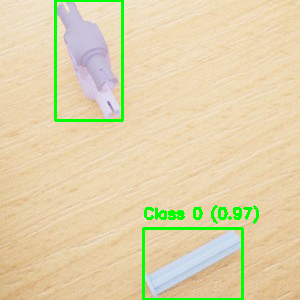

In [36]:
import cv2
from google.colab.patches import cv2_imshow
# Run inference on the test dataset
new_results = best_model('/content/yolov8_dataset/test/010499e6-e66e-11eb-af36-b0c090bd3910.jpg')

# Iterate over the results to extract bounding boxes and other information
for result in new_results:
    # Read the original image
    image = cv2.imread(result.path)  # Read the image using OpenCV

    # Accessing bounding boxes
    boxes = result.boxes.xyxy  # Bounding box coordinates (x1, y1, x2, y2)
    class_ids = result.boxes.cls  # Class IDs for each detection
    confidences = result.boxes.conf  # Confidence scores for each detection

    # Draw bounding boxes on the image
    for j in range(len(boxes)):
        x1, y1, x2, y2 = map(int, boxes[j])  # Convert to integer coordinates
        class_id = int(class_ids[j])  # Convert to integer class ID
        confidence = confidences[j]  # Get confidence score

        # Define the color and label for the bounding box
        color = (0, 255, 0)  # Green color for bounding box
        label = f"Class {class_id} ({confidence:.2f})"  # Label with class ID and confidence score

        # Draw the bounding box and label on the image
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)  # Draw rectangle
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)  # Draw label

    # Display the image with bounding boxes
    cv2_imshow(image)  # Show the image